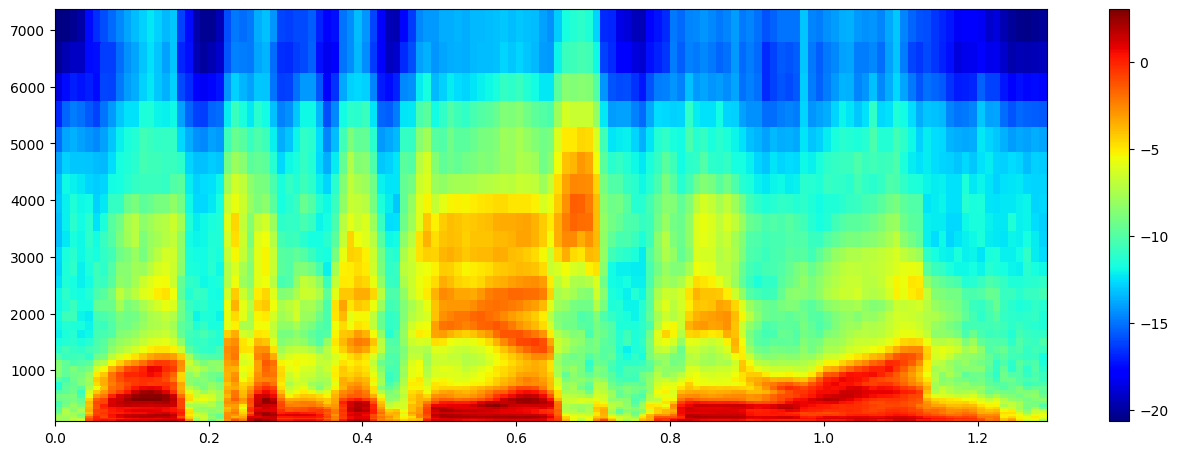

In [1]:
# Obtain Gammatone-weighted short-time power spectra
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from audlib.quickstart import welcome
from audlib.sig.transform import stpowspec
from audlib.sig.window import hamming
from audlib.plot import specgram
from audlib.sig.fbanks import Gammatone

sig, sr = welcome()
wlen = .025
hop = .01
nfft = 1024
wind = hamming(int(wlen*sr))
powerspec = stpowspec(sig, wind, int(hop*sr), nfft, synth=False)
gtbank = Gammatone(sr, 40)

wts = gtbank.gammawgt(nfft, powernorm=True, squared=True)
gammaspec_wc = powerspec @ wts

fig = plt.figure(figsize=(16, 12), dpi= 100)
ax1 = fig.add_subplot(211)
specgram(np.log(gammaspec_wc), ax1, time_axis=np.arange(gammaspec_wc.shape[0])*hop, freq_axis=gtbank.cf)

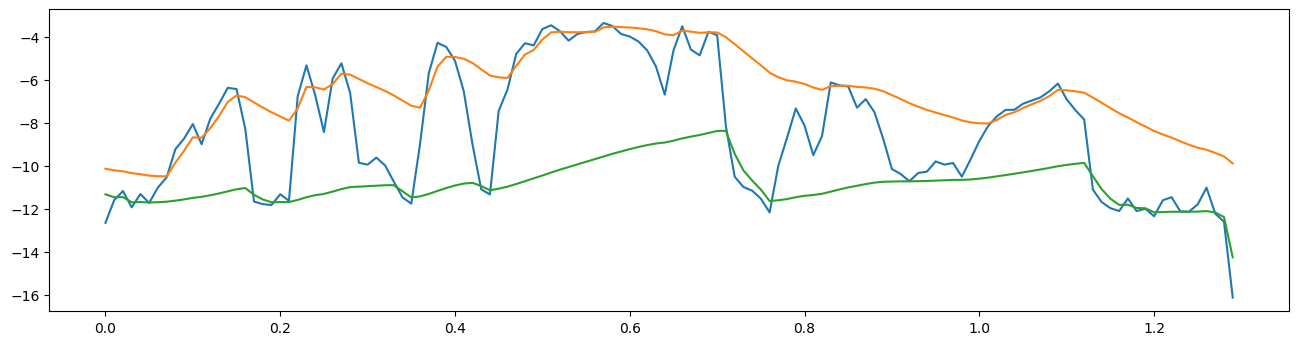

In [2]:
# Test asymmetric filter
from audlib.sig.util import asymfilt

kk = 10
pcontour = np.log(gammaspec_wc[:, kk])
upperenv = asymfilt(pcontour[:, np.newaxis], .5, .95, zi=np.zeros(1)-10)
lowerenv = asymfilt(pcontour[:, np.newaxis], .98, .5, zi=np.zeros(1)-10)

fig = plt.figure(figsize=(16, 4), dpi=100)
ax1 = fig.add_subplot(111)
tt = np.arange(gammaspec_wc.shape[0])*hop
ax1.plot(tt, pcontour, label=f"Power contour of channel [{kk}]")
ax1.plot(tt, upperenv, label=r"Upper envelope with \lambda_a = .5, \lambda_b = .95")
ax1.plot(tt, lowerenv, label=r"Lower envelope with \lambda_a = .999, \lambda_b = .5")

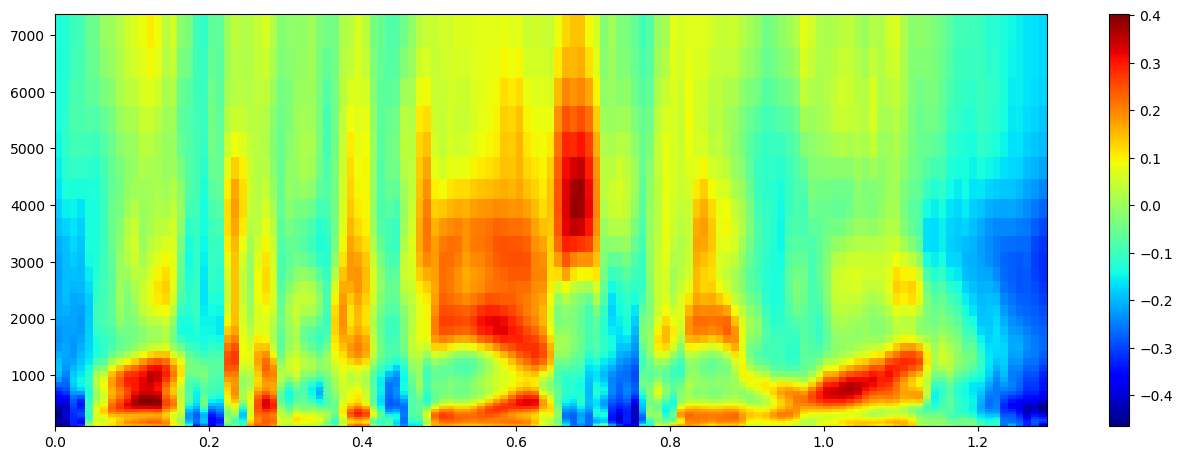

In [3]:
# Compute PNCC
from audlib.sig.spectemp import pnspec

gammaspec_pncc = pnspec(gammaspec_wc)

fig = plt.figure(figsize=(16, 12), dpi= 100)
ax1 = fig.add_subplot(211)
specgram(gammaspec_pncc, ax1, time_axis=np.arange(gammaspec_wc.shape[0])*hop, freq_axis=gtbank.cf)

In [4]:
# Demo noise robustness
import random
from audlib.data.enhance import RandSample, Additive

SR = 16000  # fix sampling rate
wsjspeech = RandSample("/home/xyy/data/wsj0/", minlen=1., maxlen=2., unit='second',
                       filt=lambda p: p.endswith(('.wv1', '.wv2')))
noizeus = RandSample("/home/xyy/Documents/MATLAB/loizou/Databases/noise16k/", minlen=2.)
wsj_noizues = Additive(wsjspeech, noizeus, snrs=[-10])  # noisy speech dataset

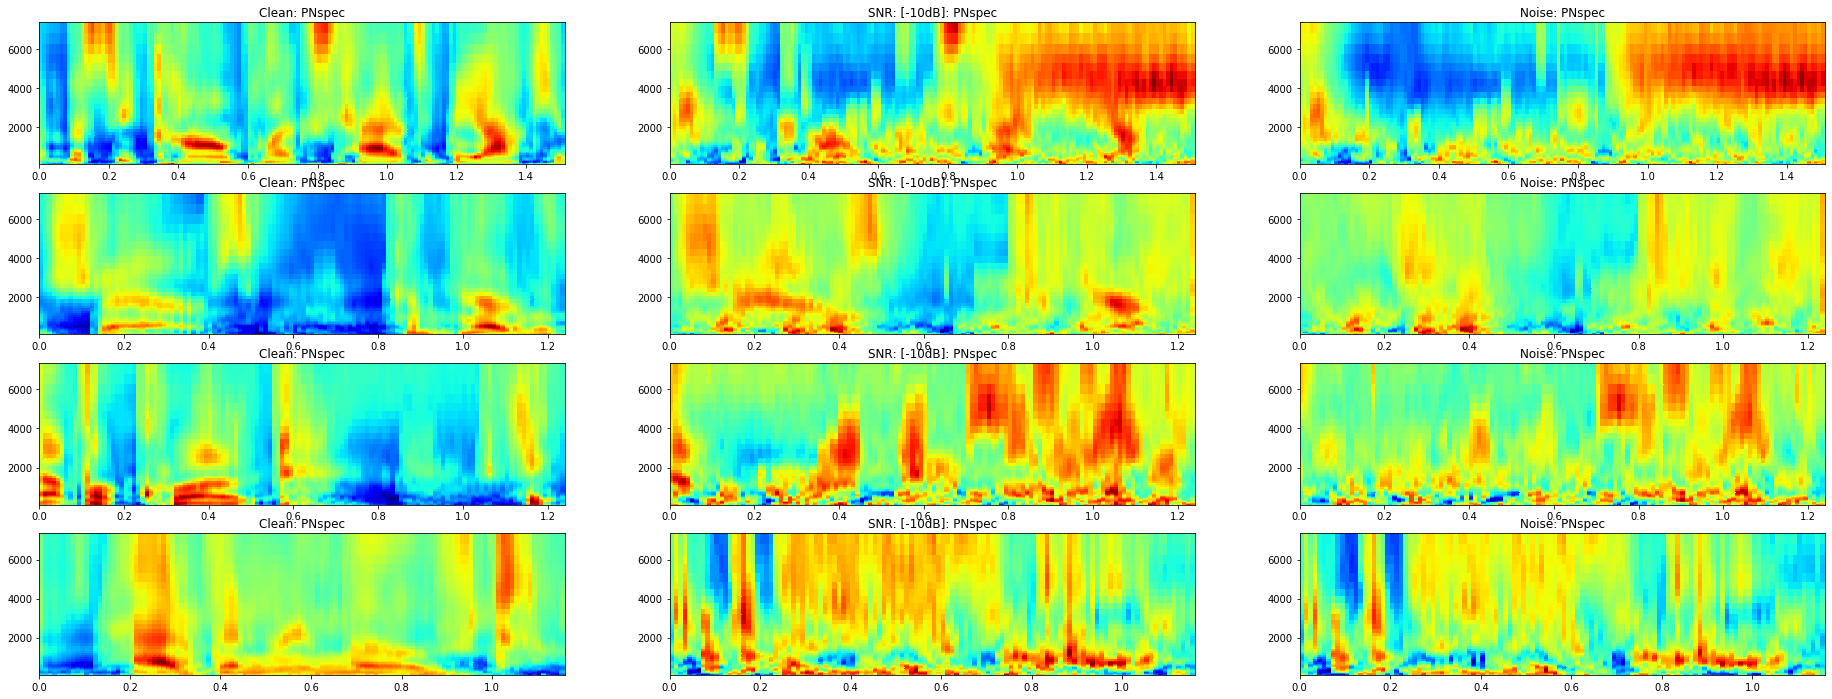

In [5]:
# Run this block many times to see how PNCC spectra is affected by different noise types
fig = plt.figure(figsize=(32, 12))
nsamps = 4
for ii in range(nsamps):
    sample = wsj_noizues[random.randrange(len(wsj_noizues))]
    for jj, sig in enumerate((sample.clean.signal, sample.noisy.signal, sample.noisy.signal-sample.clean.signal)):
        gammaspec = stpowspec(sig, wind, int(hop*sr), nfft, synth=False) @ wts
        ax = fig.add_subplot(nsamps,3,3*ii+jj+1)
        if jj == 0:
            specgram(pnspec(gammaspec), ax, time_axis=np.arange(gammaspec.shape[0])*hop, freq_axis=gtbank.cf, colorbar=False)
            ax.set_title('Clean: PNspec')
        elif jj == 1:
            specgram(pnspec(gammaspec), ax, time_axis=np.arange(gammaspec.shape[0])*hop, freq_axis=gtbank.cf, colorbar=False)
            ax.set_title(f'SNR: [{sample.snr}dB]: PNspec')
        else:
            specgram(pnspec(gammaspec), ax, time_axis=np.arange(gammaspec.shape[0])*hop, freq_axis=gtbank.cf, colorbar=False)
            ax.set_title(f'Noise: PNspec')